## Traveling Salesman Problem
The Traveling Salesman Problem (TSP) concerns finding the shortest path that a traveling salesman can take to go through a list of cities in the shortest time possible. This problem is represented in a graph $G =(V,E)$. Each vertex in the graph $G$ represents a different camp, while the weights on each of the edges $(u,v)$ represent the distance between the two camps $u$ and $v$. 

This is an NP-Hard problem, and there is no known classical algorithm that is know to solve this problem in linear time. 

In [70]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

from qibo.symbols import Z, X, Y
from qibo import hamiltonians

import numpy as np
from qibo import models, hamiltonians

from qibo.states import CircuitResult
from qibo import gates
from qibo.models import Circuit

import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from IPython.display import clear_output
InteractiveShell.ast_node_interactivity = 'all'

# Installing Dependencies

In [1]:
# installing necessary modules
! pip install networkx
! pip install qibo --user

# Introductory Challenge  

The initial task in this challenge requires you to determine a Hamiltonian that can effectively solve the Traveling Salesman Problem (TSP). 
To achieve this, a set of functions has been provided for you to complete, enabling you to find the solution using both Quantum Alternating Operator Ansatz (QAOA) and Adiabatic Quantum Optimization (AQO).

To solve this challenge, you will need to accomplish the following tasks:
1. Construct the cost, mixer, and initial Symbolic Hamiltonians that will be used for QAOA and AQO.
2. Prepare a suitable initial state for the system.
3. print and visualize your results. 
4. calculate the Fidelity of your results for both QAOA and AQO. 

## Graph construction

We first have to define the different camps and distances using a graph. Here you can find the definition of these camps:

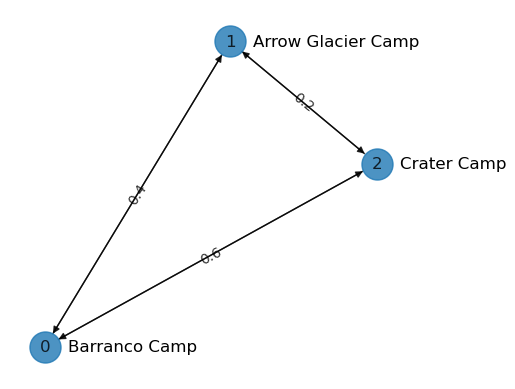

In [11]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.4)
G.add_edge(1, 0, weight=0.4)

G.add_edge(0, 2, weight=0.6)
G.add_edge(2, 0, weight=0.6)

G.add_edge(1, 2, weight=0.2)
G.add_edge(2, 1, weight=0.2)


# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

#positions of the nodes
pos = {0: np.array([-0.3, -0.3 ]), 1: np.array([-0.06 ,  0.2]), 2: np.array([0.13, 0. ])}

# creating node labels
labels = {}
labels[0] = 'Barranco Camp'
labels[1] = 'Arrow Glacier Camp'
labels[2] = 'Crater Camp'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1
plt.gcf().set_size_inches(factor * figure_size)

plt.show()

## Solution 

In [3]:
from qibo.symbols import Z, X, Y
from qibo import hamiltonians

A = 100  # coefficient of the constraints (needs to be way bigger than edge weights, but not too big either)

def build_TSP_hamiltonian(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the cost hamiltonian.

    args: 
        G: a networkx graph
            the graph representing the camp distribution. 
            
    
    returns:
        The symbolic cost hamiltonian of the TSP with respect to the nodes specified in the graph
    '''
    N = G.number_of_nodes()
    
    # definition of the symbolic hamiltonian using Qibo symbols
    sham1 = sum((G[i][j]["weight"]/4 * sum(((1-Z(i + N*t)) * (1-Z(j + N*(t+1)))) for t in range(N-1))) for i, j in G.edges())
    sham2 = sum(((1 - 1/2 * sum((1-Z(i + N*t)) for t in range(N)))**2) for i in G.nodes())
    sham3 = sum(((1 - 1/2 * sum((1-Z(i + N*t)) for i in G.nodes()))**2) for t in range(N))
    
    sham = sham1 + A * (sham2 + sham3)   
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the quantum alternating operator ansatz (QAOA).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The symbolic mixer hamiltonian of the TSP with respect to the nodes specified in the graph

    '''
    N = G.number_of_nodes()
    sham = sum((sum((X(i + N*t)) for i in range(G.number_of_nodes() ))) for t in range(G.number_of_nodes()))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the initial hamiltonian for the adiabatic quantum optimization (AQO).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        A symbolic hamiltonian representing the initial hamiltonian that will be used in the adiabatic optimization. 

    '''
    N = G.number_of_nodes()
    sham = sum((sum((X(i + N*t)) for i in range(N))) for t in range(N))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def prepare_initial_state(G: nx.Graph):
    '''
    prepare the initial state of the system.

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The initial state of the system.

    '''
    nbqubits = G.number_of_nodes()**2
    initial_state = np.ones(2**nbqubits) / 2**(nqubits//2)    # state ket(+) x ket(+) x ... x ket(+)
    
    return initial_state

def display_solution(state: str):
    '''
    display the solution of the TSP.

    args:
        state: string 
            A string encoding the TSP solution
    '''
    N = int(np.sqrt(len(state)))
    for t in range(N) :
        for i in range(N) :
            if state[i + N*t] == '1' : 
                print("Step "+str(t)+": camp "+str(i))
    # print(f'Solution: \n {state}') 

## Quantum Alternating Operator Ansatz (QAOA)

In [99]:
import numpy as np
from qibo import models, hamiltonians

nqubits = G.number_of_nodes() ** 2
print("Number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian(G)
# print(f'Hamiltonian: \n {hamiltonian}')

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian(G)
# print(f'Mixer Hamiltonian: \n {mixer_hamiltonian}')

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 8
initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state(G) 
# print(f'Initial State: \n {initial_state}')

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters, 
    method="BFGS", 
    initial_state=initial_state)

print("best energy: ", best_energy)

Number of qubits needed to solve the problem:  9
best energy:  779.6501893419434


In [100]:
from qibo.states import CircuitResult
from qibo import gates
from qibo.models import Circuit

# build the circuit using the optimal parameters optimized by QAOA
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(initial_state)

# measure the output of the circuit and obtain results
nshots= 4000
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit, quantum_state, nshots=nshots)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)
qaoa_solution = ordered_freq_counter[0][0]

display_solution(qaoa_solution) # QAOA solution is a binary string containing the solution 

Step 0: camp 1
Step 1: camp 0
Step 2: camp 2


In [103]:
qaoa_solution

'010100001'

In [102]:
ket_0 = np.array([1. +0j, 0+0j])
ket_1 = np.array([0 +0j, 1+0j])
if qaoa_solution[0] == '1':
    solution_state = ket_0
else:
    solution_state = ket_1

for i in range(1,len(qaoa_solution)):
    # print(i)
    # print(qaoa_solution[i])
    if qaoa_solution[i] == '1':
        solution_state = np.kron(solution_state,ket_0)
    else:
        solution_state = np.kron(solution_state,ket_1)
print(solution_state)

In [104]:
np.kron(ket_1,ket_0)

array([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

In [105]:
# solution_state
sum(solution_state)

(1+0j)

In [106]:
np.dot(quantum_state,solution_state)
'''
00001
00010
00100
01000
10000
'''

'\n00001\n00010\n00100\n01000\n10000\n'

## Adiabatic Quantum Optimization

In [7]:
import numpy as np
from qibo.models.evolution import AdiabaticEvolution
from qibo.hamiltonians.hamiltonians import Hamiltonian

# build initial (H0) and target (H1) hamiltonians
H1 = build_TSP_hamiltonian(G)
H0 = build_initial_hamiltonian(G)

dt = 0.1
nqubits = (G.number_of_nodes()) ** 2

# calculate the dense hamiltonian from the symbolic hamiltonian
H1_dense = Hamiltonian(nqubits, H1.matrix)
H0_dense = Hamiltonian(nqubits, H0.matrix)

# define the scheduler
def s(t): return t

# construct the adiabatic model
adiabatic_model = AdiabaticEvolution(H0_dense, H1_dense, s, dt)

[Qibo 0.1.13|WARNING|2023-05-07 06:03:30]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.1.13|WARNING|2023-05-07 06:03:33]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [8]:
# execute the adiabatic optimization
T = 10 #final time to decide the amount of steps
adiabatic_quantum_state = adiabatic_model.execute(final_time=T) 

# obtain the state with the highest probability
solution_dec = (np.abs(adiabatic_quantum_state) ** 2).argmax()

adiabatic_solution = "{0:0{bits}b}".format(solution_dec, bits=nqubits)

display_solution(adiabatic_solution) # adiabatic solution is a binary string containing the solution

Step 0: camp 2
Step 1: camp 1
Step 2: camp 0


In [42]:
solution_dec

84

# Real Life Challenges 

In this challenge, you will be tasked with solving TSP for an extended graph on a quantum computer that has a limited number of qubits. Specifically, the quantum computer will only have 6 qubits available. Moreover, the extended graph includes two new nodes a starting and ending locations. Your solution must begin at the starting point which is Karanga Camp and end at the Kibo peak.

To solve this challenge, you will need to accomplish the following tasks:

1. Design and build a new Hamiltonian that takes into account the lack of qubits and the addition of the two new nodes.
2. Calculate and analyze the fidelity of both the AQO and QAOA solutions.
3. Experiment with different scheduling strategies to improve the fidelity of your solution.

It is important that you document the steps you follow and your findings in a clear and concise manner. Good luck!

## Graph construction 

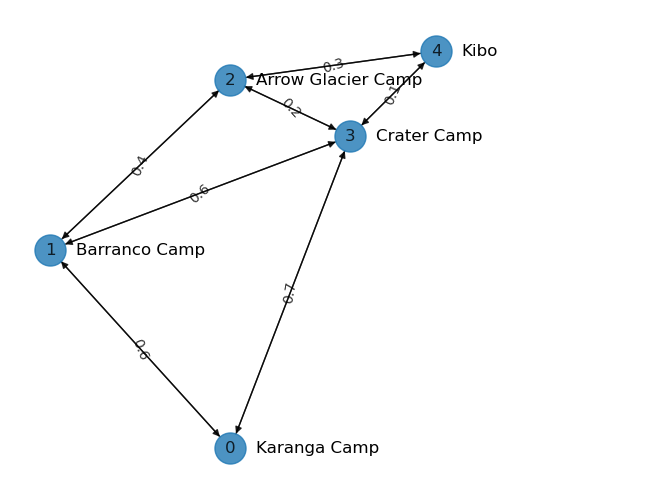

In [65]:
import matplotlib.pylab as plt
import networkx as nx
import numpy as np 

# define a directed graph 
G = nx.DiGraph()

# define the edges of the graph with their corresponding weights
G.add_edge(0, 1, weight=0.6)
G.add_edge(1, 0, weight=0.6)

G.add_edge(0, 3, weight=0.7)
G.add_edge(3, 0, weight=0.7)

G.add_edge(1, 3, weight=0.6)
G.add_edge(3, 1, weight=0.6)

G.add_edge(1, 2, weight=0.4)
G.add_edge(2, 1, weight=0.4)

G.add_edge(2, 3, weight=0.2)
G.add_edge(3, 2, weight=0.2)

G.add_edge(3, 4, weight=0.1)
G.add_edge(4, 3, weight=0.1)

G.add_edge(2, 4, weight=0.3)
G.add_edge(4, 2, weight=0.3)



# save the labels of the various edges to be able to plot them.
edge_labels= {}
for (u,v) in G.edges():
    edge_labels[(u,v)] = G[u][v]["weight"]

pos = {0: np.array([0.01, -1 ]), 1: np.array([-0.2, -0.3 ]), 2: np.array([0.01 ,  0.3]), 3: np.array([0.15, 0.1 ]), 4: np.array([0.25, 0.4 ])}

# creating node labels
labels = {}
labels[0] = 'Karanga Camp'
labels[1] = 'Barranco Camp'
labels[2] = 'Arrow Glacier Camp'
labels[3] = 'Crater Camp'
labels[4] = 'Kibo'

# applying a shift to the node labels for readability purposes 
shift = np.array([0.03, 0])
shifted_pos ={node: node_pos + shift for (node, node_pos) in pos.items()}

# draw node labels
nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")


#plot the graph and the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, alpha=0.8)
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500)

# adjust frame to avoid cutting text, may need to adjust the value
axis = plt.gca()
lim = axis.get_xlim()
axis.set_xlim([lim[0], lim[1] * 1.7])

# increase the size of the figure
figure_size = plt.gcf().get_size_inches()
factor = 1.3
plt.gcf().set_size_inches(factor * figure_size)

plt.show()

G_5 = G.copy()

In [66]:
''' Fill the missing edge w/ Inf weight'''
# HIGH_WEIGHT = float('inf')
HIGH_WEIGHT = 100
N = G.number_of_nodes()
for i in range(N):
    for j in range(N):
        if not G.has_edge(i, j):
            G.add_edge(i, j, weight = HIGH_WEIGHT)
            G.add_edge(j, i, weight = HIGH_WEIGHT)

### Solution 2 - Part 1: reducing to a 3 nodes problem

Considering the TSP on a N-node graph with fixed starting and ending point, we can transform our cost hamiltonian to simplify our problem to a normal TSP on a (N-2)-node graph. This consist in noting that the elements $x_{i,t}$ are all determined for $i \in {0, N-1}$ and $t \in {0, N-1}$, so that we can reduce the Hilbert space of our solutions to $i \in \{1, 2,..., N-2\}$ and $t \in \{1, 2,..., N-2\}$ (encoded in $(N-2)^2$ qubits) by adding the following terms in the cost hamiltonian:

$$C_{\text{ini}} = \sum_{i=1}^{N-2} w_{1, i} x_{i, 1}, \\
C_{\text{fin}} = \sum_{i=1}^{N-2} w_{i, N-1} x_{i, N-2}.$$

The first term $C_{\text{ini}}$ corresponds to the weight of the first taken edge, and the second term $C_{\text{fin}}$ to the weight of the last taken edge.

In [14]:
def build_TSP_hamiltonian_part1(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the cost hamiltonian.

    args: 
        G: a networkx graph
            the graph representing the camp distribution. 
            
    
    returns:
        The symbolic cost hamiltonian of the TSP with respect to the nodes specified in the graph
    '''
    N = G.number_of_nodes()
    n = N-2
    
    # definition of the symbolic hamiltonian using Qibo symbols
    sham1 = sum((G[i+1][j+1]["weight"]/4 * (1-Z(i + n*t)) * (1-Z(j + n*(t+1)))) for t in range(n-1) for i in range(n) for j in range(n))
    sham2 = sum(((1 - 1/2 * sum((1-Z(i + n*t)) for t in range(n)))**2) for i in range(n))
    sham3 = sum(((1 - 1/2 * sum((1-Z(i + n*t)) for i in range(n)))**2) for t in range(n))
    
    shamini = sum((G[0][i+1]["weight"] * (1-Z(i + n*1))/2) for i in range(n))
    shamfin = sum((G[i+1][N-1]["weight"] * (1-Z(i + n*(N-2)))/2) for i in range(n))
    
    sham = sham1 + A * (sham2 + sham3 + shamini + shamfin)
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_mixer_hamiltonian_part1(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the quantum alternating operator ansatz (QAOA).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The symbolic mixer hamiltonian of the TSP with respect to the nodes specified in the graph

    '''
    N = G.number_of_nodes()
    n = N-2
    sham = sum((sum((X(i + n*t)) for i in range(n))) for t in range(n))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_initial_hamiltonian_part1(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the initial hamiltonian for the adiabatic quantum optimization (AQO).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        A symbolic hamiltonian representing the initial hamiltonian that will be used in the adiabatic optimization. 

    '''
    N = G.number_of_nodes()
    n = N-2
    
    sham = sum((sum((X(i + n*t)) for i in range(n))) for t in range(n))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def prepare_initial_state_part1(G: nx.Graph):
    '''
    prepare the initial state of the system.

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The initial state of the system.

    '''
    nbqubits = (G.number_of_nodes()-2)**2
    initial_state = np.ones(2**nbqubits) / 2**(nqubits//2)    # state ket(+) x ket(+) x ... x ket(+)
    
    return initial_state

def display_solution_part1(state: str):
    '''
    display the solution of the TSP.

    args:
        state: string 
            A string encoding the TSP solution
    '''
    n = int(np.sqrt(len(state)))
    print("Step 0: camp 0")
    for t in range(n) :
        for i in range(n) :
            if state[i + n*t] == '1' : 
                print("Step "+str(t+1)+": camp "+str(i+1))
    print("Step "+str(n+1)+": camp "+str(n+1))

## Solution 2 - Part 2: Taking advantage of the redundancy in the conditions

Once considering a graph of n nodes with no specified starting and ending points, we can further reduce the number of required qubits by noting that once all but one nodes are selected, the last node of the tour is fully determined. 

This property comes from the condition
$$ \forall t, \sum_{i=0}^{n-1}x_{i,t} = 1, $$
which we can rewrite as:
$$\forall t, x_{n-1, t} = 1 - \sum_{i=0}^{n-2}x_{i,t}.$$
Our solution can thus be entirely described by the $n(n-1)$ binary variables $x_{i, t}$ for $i \in \{0,...,n-2\}$ and $t \in \{0,...,n-1\}$, if we apply some modifications on the cost function that we describe hereafter. 

To be consistent with the physical interpretation of our solution, we need to constraint the quantity $1 - \sum_{i=0}^{n-2}x_{i,t}$ to be in $\{0, 1\}$,
$$x_{n-1, t} := 1 - \sum_{i=0}^{n-2}x_{i,t}\in\{0, 1\},$$
which is no more ensure by definition. As the $x_{i, t}$ are binary variables for $i \in \{0,...,n-2\}$, we know however $x_{n-1, t}\in\{2-n,...,1\}$. In these conditions, the above constraint thus reduces to 
$$x_{n-1, t} = 1 - \sum_{i=0}^{n-2}x_{i,t}\in[0, 1],$$
which can be encoded in the following Hamiltonian:
$$C_{\text{bin}} = \sum_{t=0}^{n-1} (x_{n-1, t} - \frac{1}{2})^2.$$

which reduces the space of feasible solutions to a Hilbert space of size $n(n-1)$ (the $n$ factor coming from $t\in\{0, 1,..., n-1\}$ and the $n-1$ factor from $i\in\{0, 1,... n-2\}$).

We thus consider the above constraint on steps fully satisfied and set 

Doing so, the main term of the cost Hamiltonian reads:

$$C_0(x) = \sum_{i,j=0}^{n-2}w_{i,j}\sum_{t=0}^{n-1}x_{i,t}x_{j,t+1} + 2\sum_{j=0}^{n-2}w_{n-1,j}\sum_{t=0}^{n-1}(1-\sum_{k=0}^{n-2}x_{k,t})x_{j,t+1},$$

and the constraint on nodes:

$$C_1(x) = \sum_{i=0}^{n-2}(1-\sum_{t=0}^{n-1}x_{i,t})^2 + (\sum_{k=0}^{n-2}\sum_{t=0}^{n-1}x_{i,t} - (n-1))^2.$$

Zooming out and remembering that our n-nodes graph is part of a (n+2)-nodes graph with fixed starting and ending points, we also need to transform the costs from the initial and final edges:

$$C_{\text{ini}}(x) = \sum_{i=0}^{n-2}(w_{-1, i} - w_{-1, n-1})x_{i,0} + w_{-1, n-1},$$

$$C_{\text{fin}}(x) = \sum_{i=0}^{n-2}(w_{i, n} - w_{n-1, n})x_{i,n-1} + w_{n-1, n}.$$

Remark: here, $w_{i,j}$ corresponds to $G[i+1][j+1]["weight"]$ in the code, with G the big graph.

In [79]:
A = 10

def build_TSP_hamiltonian_part2(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the cost hamiltonian.

    args: 
        G: a networkx graph
            the graph representing the camp distribution. 
            
    
    returns:
        The symbolic cost hamiltonian of the TSP with respect to the nodes specified in the graph
    '''
    N = G.number_of_nodes()
    n = N-2

    sham_main = sum((G[i+1][j+1]["weight"] * (1-Z(i + (n-1)*t))/2 * (1-Z(j + (n-1)*(t+1)))/2) for t in range(n-1) for i in range(n-1) for j in range(n-1))
    sham_main += 2 * sum((G[(n-1)+1][j+1]["weight"] * (1 - sum((1-Z(k+(n-1)*t))/2 for k in range(n-1))) * (1-Z(j + (n-1)*(t+1)))/2) for t in range(n-1) for j in range(n-1))
    # print(sham_main)
    
    sham_nodes = sum(((1 - 1/2 * sum((1-Z(i + (n-1)*t)) for t in range(n)))**2) for i in range(n-1))
    # print('sham node1',sham_nodes)
    sham_nodes += (sum((1-Z(k + (n-1)*t))/2 for k in range(n-1) for t in range(n)) - (n-1))**2
    # print('sham node2',sham_nodes)
    
    sham_ini = sum(((G[0][i+1]["weight"]-G[0][n]["weight"]) * (1-Z(i + (n-1)*1))/2) for i in range(n-1)) + G[0][n]["weight"]
    # print(sham_ini)
    sham_fin = sum(((G[i+1][n+1]["weight"]-G[n][n+1]["weight"]) * (1-Z(i + (n-1)*1))/2) for i in range(n-1)) + G[n][n+1]["weight"]
    # print(sham_fin)
    
    sham_bin = sum(((1 - sum((1-Z(k+(n-1)*t))/2 for k in range(n-1)))-1/2)**2 for t in range(n))
    # print(sham_bin)
        
    sham = sham_main + A * (2*sham_nodes + sham_ini + sham_fin + sham_bin)
    # print(f'sham_main: {hamiltonians.SymbolicHamiltonian(sham_main).matrix}')
#     print(f'sham_ini: {hamiltonians.SymbolicHamiltonian(sham_ini).matrix.shape}')
#     print(f'sham_fin: {hamiltonians.SymbolicHamiltonian(sham_fin).matrix.shape}')
#     print(f'sham_bin: {hamiltonians.SymbolicHamiltonian(sham_bin).matrix.shape}')

#     print(f'sham: {hamiltonians.SymbolicHamiltonian(sham).matrix.shape}')
    # print(sham)
    return hamiltonians.SymbolicHamiltonian(sham)

hamiltonian = build_TSP_hamiltonian_part2(G)

In [72]:
hamiltonian.matrix

[Qibo 0.1.13|WARNING|2023-05-07 10:57:22]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


array([[  75.5+0.j,    0. +0.j,    0. +0.j, ...,    0. +0.j,    0. +0.j,
           0. +0.j],
       [   0. +0.j,   35.9+0.j,    0. +0.j, ...,    0. +0.j,    0. +0.j,
           0. +0.j],
       [   0. +0.j,    0. +0.j,   36.7+0.j, ...,    0. +0.j,    0. +0.j,
           0. +0.j],
       ...,
       [   0. +0.j,    0. +0.j,    0. +0.j, ..., 2487.7+0.j,    0. +0.j,
           0. +0.j],
       [   0. +0.j,    0. +0.j,    0. +0.j, ...,    0. +0.j, 2486.9+0.j,
           0. +0.j],
       [   0. +0.j,    0. +0.j,    0. +0.j, ...,    0. +0.j,    0. +0.j,
        2706.9+0.j]])

In [75]:
w, v = np.linalg.eig(hamiltonian.matrix)
# print(w)
# print(v)

ground_index = np.where(w == min(w))

v[ground_index]

np.where(v[ground_index] == 1+0j)

bin(33-1)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

(array([0]), array([33]))

'0b100000'

In [76]:
def build_mixer_hamiltonian_part2(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the mixer hamiltonian for the quantum alternating operator ansatz (QAOA).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The symbolic mixer hamiltonian of the TSP with respect to the nodes specified in the graph

    '''
    N = G.number_of_nodes()
    n = N-2
    sham = sum(X(i + (n-1)*t) for i in range(n-1) for t in range(n))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def build_initial_hamiltonian_part2(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    '''
    build the initial hamiltonian for the adiabatic quantum optimization (AQO).

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        A symbolic hamiltonian representing the initial hamiltonian that will be used in the adiabatic optimization. 

    '''
    N = G.number_of_nodes()
    n = N-2
    sham = sum((sum((X(i + (n-1)*t)) for i in range(n-1))) for t in range(n))
    
    return hamiltonians.SymbolicHamiltonian(sham)

def prepare_initial_state_part2(G: nx.Graph):
    '''
    prepare the initial state of the system.

    args:
        G: a networkx graph
            the graph representing the camp distribution. 

    returns:
        The initial state of the system.

    '''
    nbqubits = (G.number_of_nodes()-2)*(G.number_of_nodes()-3)
    initial_state = np.ones(2**nbqubits) / 2**(nqubits//2)    # state ket(+) x ket(+) x ... x ket(+)
    return initial_state

def display_solution_part2(state: str):
    '''
    display the solution of the TSP.

    args:
        state: string 
            A string encoding the TSP solution
    '''
    n = int(1/2 + np.sqrt(len(state)+1/4))
    print("Step 0: camp 0")
    for t in range(n) :
        bool_lastnode = True
        for i in range(n-1) :
            if state[i + (n-1)*t] == '1' : 
                print("Step "+str(t+1)+": camp "+str(i+1))
                bool_lastnode = False
        if bool_lastnode :
            print("Step "+str(t+1)+": camp "+str(n-1))
    print("Step "+str(n)+": camp "+str(n))

In [77]:
nqubits = (G.number_of_nodes()-3)*(G.number_of_nodes()-2)
print("Number of qubits needed to solve the problem: ", nqubits)

# create the cost Hamiltonian for the given graph
hamiltonian = build_TSP_hamiltonian_part2(G)
# print(f'Hamiltonian: \n {hamiltonian}')

# create the mixer Hamiltonian for the given graph
mixer_hamiltonian = build_mixer_hamiltonian_part2(G)
# print(f'Mixer Hamiltonian: \n {mixer_hamiltonian}')

# create QAOA model given the Hamiltonians
qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

# optimize using random initial variational parameters with eight layers 
# Note: you can change the number of layers but it has to be an even number
num_layers = 8
initial_parameters = np.random.random(num_layers) 

# prepare the initial state of the QAOA optimization 
initial_state = prepare_initial_state_part2(G) 
# print(f'Initial State: \n {initial_state}')

# run the QAOA optimization with the initial parameters and the hamiltonians defined
best_energy, final_parameters, extra = qaoa.minimize(
    initial_parameters,
    method="BFGS", 
    initial_state=initial_state)

print("best energy: ", best_energy)

Number of qubits needed to solve the problem:  6
best energy:  606.4429124018735


In [78]:
# build the circuit using the optimal parameters optimized by QAOA
qaoa.set_parameters(final_parameters)
quantum_state = qaoa.execute(initial_state)

# measure the output of the circuit and obtain results
nshots= 4000
circuit = Circuit(nqubits)
circuit.add(gates.M(*range(nqubits)))
result = CircuitResult(qaoa.backend, circuit, quantum_state, nshots=nshots)
freq_counter = result.frequencies()

# order the results according to the frequencies
ordered_freq_counter = sorted(freq_counter.items(), key=lambda item: item[1], reverse=True)
qaoa_solution = ordered_freq_counter[0][0]
print(qaoa_solution)
display_solution_part2(qaoa_solution) # QAOA solution is a binary string containing the solution 

MeasurementResult(qubits=(0, 1, 2, 3, 4, 5), nshots=0)

000000
Step 0: camp 0
Step 1: camp 2
Step 2: camp 2
Step 3: camp 2
Step 3: camp 3


In [85]:
# Benchmark

# conversion of the right solution in the ket representation
ket_0 = np.array([1. +0j, 0+0j])
ket_1 = np.array([0 +0j, 1+0j])
right_solution = np.array([0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0])
if right_solution[0] == '1':
    right_solution_state = ket_0
else:
    right_solution_state = ket_1
or i in range(1,len(right_solution)):
    # print(i)
    # print(qaoa_solution[i])
    if right_solution[i] == '1':
        right_solution_state = np.kron(solution_state,ket_0)
    else:
        right_solution_state = np.kron(solution_state,ket_1)

print('State of our the QAOA solution :',solution_state)
print('State of the right classical solution :', right_solution_state)


ValueError: cannot reshape array of size 512 into shape (2,2,2,2,2,2)

### Classic TSP Solver

In [116]:
G_5_dummy = G_5.copy()

G_5_dummy.add_edge(0, 5, weight=0)
G_5_dummy.add_edge(5, 0, weight=0)
G_5_dummy.add_edge(0, 4, weight=0)
G_5_dummy.add_edge(4, 0, weight=0)

nx.approximation.traveling_salesman_problem(G_5_dummy, nodes = range(4), cycle = False)

[0, 4, 3, 2, 1]

## Solution 2 - Part 3 : Divide and conquer NISQ computers

Our previous protocol provides a fully quantum implementation of the TSP problem on a N-node graph, with starting and ending points, using $(N-2)(N-3)$ qubits. This is nice, but we know that in the NISQ area we can't rely on arbitrarily big quantum computers: the number of avalaible qubits is in reality resticted to some upper value. Considering an arbitrarily big $N$-node graph, we would thus like to find a way to divide our problem into smaller problems that could be solved by our NISQ computer. To do so, we will carry out a divide-and-conquer hybrid approach.

Considering a N-node graph $G$ with starting and ending points $0$ and $N-1$, we scan every node $i$ that is connected to $0$ and look for the best solution of the TSP on the subgraph $G'=G/\{0\}$ starting from node $i$ and ending at $N-1$. Every of these subproblems requires $(N'-2)(N'-3)$ qubits, with $N'=N-1$. Supposing that we have solved this subproblems and obtains the respective optimal costs $C_i$ and optimal paths $S_i = [i,..., N-1]$, we deduce the global optimal cost as being $\max\{C_i + w_{0,i} \text{ for } i \in\{1,...,N-2\}\}$, reached for $i=i_0$. The optimal path is finally $[0]+S_{i_0}$.

## Temporarely Abandoned Solution: Optimize knowing the start and end positions

In [24]:
import numpy as np
from qibo import models, hamiltonians
from qibo.symbols import Z, X, Y
from qibo import hamiltonians

A = 100  # coefficient of the constraints (needs to be way bigger than edge weights, but not too big either)
HIGH_COEFF = 1000

Main Hamiltonian:

$$C_0(x) = \sum_{i,j=0}^{n-1}w_{i,j}\sum_{t=0}^{n-1}x_{i,t}x_{j,t+1}$$

Standard constrains hamiltonians:

Each city should be visited exactly once, which corresponds to the Hamiltonian term:

$$ H_{c_1} = \sum_{i}^{N}{(1-\sum_{t}{x_{i, t}})^2} $$

where N is the number of cities to visit and $x_{i, t} \in \{0, 1\}$ is a binary variable indicating that we visit city $i$ along some path $x$ at time step $t$.

Each timestep should only contain one city (i.e. we can’t be in multiple cities at once), corresponding to the term:

$$ H_{c_2} = \sum_{t}{(1-\sum_{i}{x_{i, t}})^2} $$

where now we sum over timesteps $t$ at the end.

In [25]:
def build_TSP_hamiltonian(G : nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    N = G.number_of_nodes()
    
    # Main hamiltonian
    H = sum((G[i][j]["weight"]/4 * sum(((1-Z(i + N*t)) * (1-Z(j + N*(t+1)))) for t in range(N-1))) for i, j in G.edges())
    
    # City visited only once:
    H += A*sum(((1 - 1/2 * sum((1-Z(i + N*t)) for t in range(N)))**2) for i in G.nodes())
    # One city visited at the time
    H += A*sum(((1 - 1/2 * sum((1-Z(i + N*t)) for i in G.nodes()))**2) for t in range(N))
    # Last link used to get to the final destination
    custom_W = []
    for i in range(1, N-1):
        try:
            custom_W.append(G[i][-1]["weight"]/2*(1-Z(i + N*3)))
        except:
            custom_W.append(HIGH_COEFF/2*(1-Z(i + N*3)))
    
    custom_W = sum(custom_W)
    H +=  custom_W
    return hamiltonians.SymbolicHamiltonian(H)

We define a standard mixer (driver) hamiltonian:

$$X = 
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}$$

$$H_{M} = \sum_{t}{\sum_{i}^{N}{X}}$$

In [ ]:
def build_mixer_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    N = G.number_of_nodes()
    H = sum((sum((X(i + N*t)) for i in range(G.number_of_nodes() ))) for t in range(G.number_of_nodes()))
    return hamiltonians.SymbolicHamiltonian(H)

def build_initial_hamiltonian(G: nx.Graph) ->  hamiltonians.SymbolicHamiltonian:
    N = G.number_of_nodes()
    n = N-2
    H = sum((sum((X(i + n*t)) for i in range(n))) for t in range(n))
    return hamiltonians.SymbolicHamiltonian(H)


def prepare_initial_state(G: nx.Graph):
    nbqubits = G.number_of_nodes()**2
    initial_state = np.ones(2**nbqubits) / 2**(nqubits//2)    # state ket(+) x ket(+) x ... x ket(+)
    
    return initial_state

def display_solution(state: str):
    n = int(np.sqrt(len(state)))
    for t in range(n) :
        for i in range(n) :
            if state[i + n*t] == '1' : 
                print("Step "+str(t)+": camp "+str(i))

In [17]:
N = G.number_of_nodes()
for i in range(N-2):
    nqubits = (G.number_of_nodes()-3)*(G.number_of_nodes()-2)
    print("number of qubits needed to solve the problem: ", nqubits)

    # create the cost Hamiltonian for the given graph
    hamiltonian = build_TSP_hamiltonian(G)
    # print(f'Hamiltonian: \n {hamiltonian}')

    # create the mixer Hamiltonian for the given graph
    mixer_hamiltonian = build_mixer_hamiltonian(G)
    # print(f'Mixer Hamiltonian: \n {mixer_hamiltonian}')

    # create QAOA model given the Hamiltonians
    qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)

    # optimize using random initial variational parameters with eight layers 
    # Note: you can change the number of layers but it has to be an even number
    num_layers = 8
    initial_parameters = np.random.random(num_layers) 

    # prepare the initial state of the QAOA optimization 
    initial_state = prepare_initial_state(G) 
    # print(f'Initial State: \n {initial_state}')

    # run the QAOA optimization with the initial parameters and the hamiltonians defined
    best_energy, final_parameters, extra = qaoa.minimize(
        initial_parameters, 
        method="BFGS", 
        initial_state=initial_state)

    print("best energy: ", best_energy)

number of qubits needed to solve the problem:  9
best energy:  849.0607597795788
